https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [1]:
import pandas as pd
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[df[target_column] >= 0]
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df[target_column] = df[target_column] + 1
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
df['y'].min()

238

Train test split

In [3]:
train = df.iloc[:-30]
test = df.iloc[-30:]

Parameter tuning for order

In [4]:
# Initiate the model
baseline_model = Prophet()# Fit the model on the training dataset
baseline_model.fit(train)

11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing


Create Model

In [5]:
baseline_model_cv = cross_validation(model=baseline_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing
11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing
11:00:37 - cmdstanpy - INFO - Chain [1] done p

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-07,11935.559069,9580.763321,14500.463498,12537,2021-01-06
1,2021-01-08,12096.272798,9612.182807,14380.380970,12708,2021-01-06
2,2021-01-09,12016.911756,9715.422401,14445.188914,13519,2021-01-06
3,2021-01-10,16029.689939,13513.622955,18518.254022,26189,2021-01-06
4,2021-01-11,11443.924949,8972.920232,13738.114596,11642,2021-01-06


Plot the result

In [6]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,8.866196e+06,2977.615787,2346.355505,1.437941,0.665933,0.879654,0.639216


RMSE of the result

In [7]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

1.4379405584949783

In [8]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.9)# Fit the model on the training dataset
manual_model.fit(train)# Cross validation
manual_model_cv = cross_validation(manual_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

11:00:38 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] done pr

1.4201076452380468

In [9]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

11:00:41 - cmdstanpy - INFO - Chain [1] start processing
11:00:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] start processing
11:00:42 - cmdstanpy - INFO - Chain [1] done processing
11:00:42 - cmdstanpy - INFO - Chain [1] done processing
11:00:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
11:00:42 - cmdstanpy - INFO - Chain [1] done processing
11:00:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated 

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [10]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation


pred = auto_model.predict(test[['ds']])
auto_model_cv = cross_validation(auto_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p

11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] done processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:33 - cmdstanpy - INFO - Chain [1] sta

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,7.634116e+06,2762.990431,1911.568166,0.6509,0.534432,0.614896,0.821569


In [11]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-10-24,139.850946,-2504.482383,2968.089722,139.850946,139.850946,-0.178101,-0.178101,-0.178101,-0.088201,-0.088201,-0.088201,-0.089899,-0.089899,-0.089899,0.0,0.0,0.0,114.943408
1,2023-10-25,134.452336,-2647.741932,2656.321336,134.452336,134.452336,-0.140899,-0.140899,-0.140899,-0.054080,-0.054080,-0.054080,-0.086819,-0.086819,-0.086819,0.0,0.0,0.0,115.508084
2,2023-10-26,129.053725,-2443.141634,2818.070496,129.053725,129.053725,-0.094133,-0.094133,-0.094133,-0.010674,-0.010674,-0.010674,-0.083459,-0.083459,-0.083459,0.0,0.0,0.0,116.905514
3,2023-10-27,123.655115,-2685.497364,2881.348297,123.655115,123.655115,-0.083557,-0.083557,-0.083557,-0.003713,-0.003713,-0.003713,-0.079844,-0.079844,-0.079844,0.0,0.0,0.0,113.322897
4,2023-10-28,118.256504,-2641.353660,2659.349394,118.256504,118.256504,-0.092307,-0.092307,-0.092307,-0.016310,-0.016310,-0.016310,-0.075997,-0.075997,-0.075997,0.0,0.0,0.0,107.340569
5,2023-10-29,112.857894,-2829.063607,2746.683699,112.857894,112.857894,0.164806,0.164806,0.164806,0.236757,0.236757,0.236757,-0.071950,-0.071950,-0.071950,0.0,0.0,0.0,131.457587
6,2023-10-30,107.459283,-2519.093721,2817.660174,107.459283,107.459283,-0.131512,-0.131512,-0.131512,-0.063778,-0.063778,-0.063778,-0.067734,-0.067734,-0.067734,0.0,0.0,0.0,93.327132
7,2023-10-31,102.060673,-2599.741823,2680.894598,102.060673,102.060673,-0.151582,-0.151582,-0.151582,-0.088201,-0.088201,-0.088201,-0.063381,-0.063381,-0.063381,0.0,0.0,0.0,86.590124
8,2023-11-01,96.662063,-2760.683627,2798.484398,96.662063,96.662063,-0.113006,-0.113006,-0.113006,-0.054080,-0.054080,-0.054080,-0.058926,-0.058926,-0.058926,0.0,0.0,0.0,85.738673
9,2023-11-02,91.263452,-2584.806099,2875.830640,91.263452,91.263452,-0.065077,-0.065077,-0.065077,-0.010674,-0.010674,-0.010674,-0.054403,-0.054403,-0.054403,0.0,0.0,0.0,85.324315


In [12]:
from metrics import print_evaluation_metrics

print_evaluation_metrics(pred['yhat'], test['y'])

Evaluation Metrics:
MSE: 71265.15
RMSE: 266.96
MAE: 258.13
MAPE: nan
SMAPE: nan


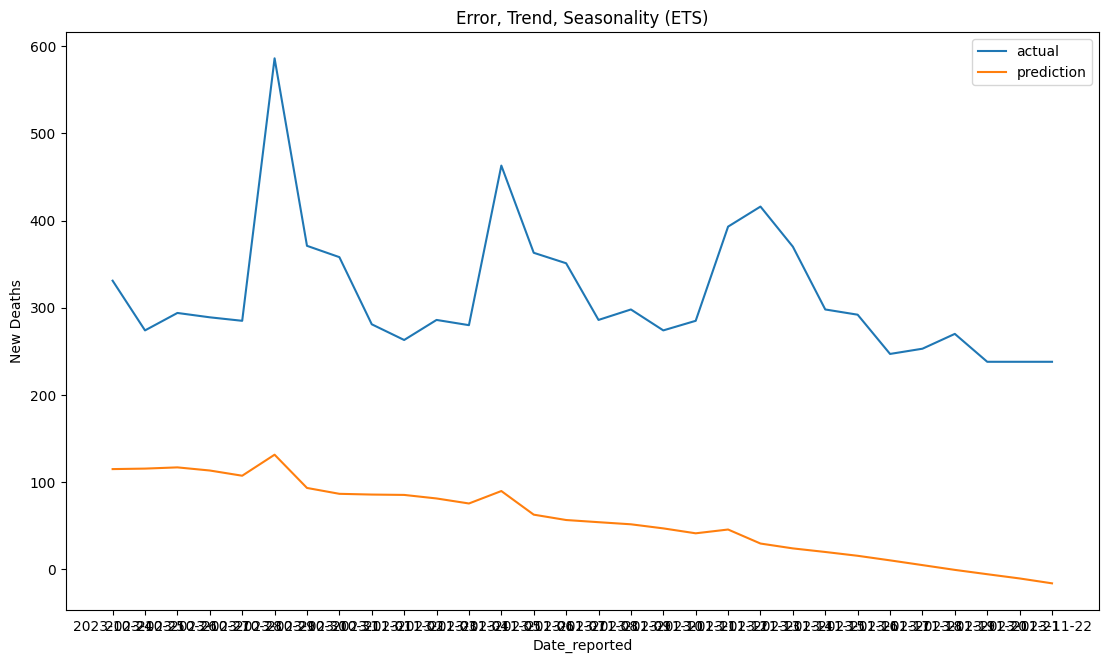

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Error, Trend, Seasonality (ETS)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [14]:
# Create a copy of the data
data_log = df.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])# Delete the stock price and rename the log scale stock price to y
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})# Take a look at the data
data_log.head()

,ds,floor,y
0,2020-01-03,0,5.472271
1,2020-01-04,0,5.472271
2,2020-01-05,0,5.480639
3,2020-01-06,0,5.472271
4,2020-01-07,0,5.472271


In [15]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p

11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] done processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] done processing
11:03:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.456342  1.567272  1.414797  0.189873  0.190188  0.169742   

   coverage  
0  0.230476  


11:03:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing
11:03:41 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.781585  1.667809  1.482476  0.196815  0.200569  0.175266   

   coverage  
0   0.25619  


11:03:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] done processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] start processing
11:03:46 - cmdstanpy - INFO - Chain [1] done processing
11:03:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
11:03

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.614764  1.617023  1.453201  0.194191  0.195476  0.173179   

   coverage  
0  0.227619  


11:03:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] done processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:51 - cmdstanpy - INFO - Chain [1] done processing
11:03:51 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.066613  1.751175  1.537872  0.202818  0.206398  0.179843   

   coverage  
0  0.234286  


11:03:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing
11:03:56 - cmdstanpy - INFO - Chain [1] start p

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  2.573146  1.604103  1.440647  0.192575  0.19598  0.171869  0.221905


11:04:05 - cmdstanpy - INFO - Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
11:04

  horizon       mse     rmse       mae      mape     mdape    smape  coverage
0 30 days  3.041361  1.74395  1.537596  0.203345  0.207107  0.18032  0.221905


11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] done processing
11:04:10 - cmdstanpy - INFO - Chain [1] done processing
11:04:10 - cmdstanpy - INFO - Chain [1] done processing
11:04:11 - cmdstanpy - INFO - Chain [1] done processing
11:04:11 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.588825  1.608983  1.445086  0.193024  0.196222  0.172261   

   coverage  
0  0.226667  


11:04:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] done processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] done processing
11:04:16 - cmdstanpy - INFO - Chain [1] done processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start processing
11:04:16 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.027955  1.740102  1.534983  0.202667  0.206743  0.179839   

   coverage  
0  0.215238  


11:04:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] done processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] start processing
11:04:22 - cmdstanpy - INFO - Chain [1] done processing
11:04:22 - cmdstanpy - INFO - Chain [1] start processing
11:04:22 - cmdstanpy - INFO - Chain [1] done processing
11:04:22 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.590632  1.609544  1.447569  0.193534  0.194893  0.172665   

   coverage  
0  0.226667  


11:04:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:26 - cmdstanpy - INFO - Chain [1] start processing
11:04:26 - cmdstanpy - INFO - Chain [1] start processing
11:04:26 - cmdstanpy - INFO - Chain [1] start processing
11:04:26 - cmdstanpy - INFO - Chain [1] done processing
11:04:26 - cmdstanpy - INFO - Chain [1] start processing
11:04:26 - cmdstanpy - INFO - Chain [1] start processing
11:04:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
11:04:27 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
11:04:27 - cmdstanpy - INFO - Chain [1] done processing
11:04:27 - cmdstanpy - INFO - Chain [1] start processing
11:04:27 - cmdstanpy - INFO - Chain [1] start processing
11:04:27 - cmdstanpy - INFO - Chain [1] done processing
11:04:27 - cmdstanpy - INFO - Chain [1] done processing
11:0

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.036575  1.742577  1.541734  0.203402  0.209761  0.180548   

   coverage  
0  0.222857  


11:04:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] done processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] done processing
11:04:33 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.330528  0.574915  0.428375  0.055775  0.043493  0.055363   

   coverage  
0  0.473333  


11:04:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] done processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] done processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
11:04:37 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.382543  0.618501  0.451454  0.058535  0.046123  0.057959   

   coverage  
0  0.445714  


11:04:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] done processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] done processing
11:04:41 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.373606  0.611233  0.449299  0.057869  0.04516  0.057324  0.474286


11:04:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] done processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] done processing
11:04:44 - cmdstanpy - INFO - Chain [1] done processing
11:04:44 - cmdstanpy - INFO - Chain [1] start processing
11:04:44 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.496183  0.704403  0.480455  0.061535  0.04416  0.060921  0.448571


11:04:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing
11:04:48 - cmdstanpy - INFO - Chain [1] done processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start processing
11:04:48 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.364691  0.603897  0.443935  0.057194  0.044349  0.056731   

   coverage  
0  0.475238  


11:04:52 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] done processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] start processing
11:04:53 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.498275  0.705886  0.481251  0.061671  0.044099  0.061051   

   coverage  
0   0.44381  


11:04:57 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] start processing
11:04:58 - cmdstanpy - INFO - Chain [1] done processing
11:04:59 - cmdstanpy - INFO - Chain [1] start processing
11:04:59 - cmdstanpy - INFO - Chain [1] done processing
11:04:59 - cmdstanpy - INFO - Chain [1] done processing
11:04:59 - cmdstanpy - INFO - Chain [1] done processing
11:04:59 - cmdstanpy - INFO - Chain [1] start processing
11:04:59 - cmdstanpy - INFO - Chain [1] start processing
11:04:59 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.374714  0.612139  0.451178  0.058147  0.045799  0.057627   

   coverage  
0  0.472381  


11:05:02 - cmdstanpy - INFO - Chain [1] start processing
11:05:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:03 - cmdstanpy - INFO - Chain [1] start processing
11:05:03 - cmdstanpy - INFO - Chain [1] start processing
11:05:03 - cmdstanpy - INFO - Chain [1] start processing
11:05:03 - cmdstanpy - INFO - Chain [1] done processing
11:05:03 - cmdstanpy - INFO - Chain [1] done processing
11:05:03 - cmdstanpy - INFO - Chain [1] start processing
11:05:03 - cmdstanpy - INFO - Chain [1] start processing
11:05:03 - cmdstanpy - INFO - Chain [1] start processing
11:05:03 - cmdstanpy - INFO - Chain [1] start processing
11:05:04 - cmdstanpy - INFO - Chain [1] done processing
11:05:04 - cmdstanpy - INFO - Chain [1] start processing
11:05:04 - cmdstanpy - INFO - Chain [1] start processing
11:05:04 - cmdstanpy - INFO - Chain [1] start processing
11:05:04 - cmdstanpy - INFO - Chain [1] start

  horizon      mse     rmse      mae      mape     mdape     smape  coverage
0 30 days  0.49639  0.70455  0.48056  0.061588  0.043785  0.060968  0.451429


11:05:07 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] done processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] done processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] done processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:08 - cmdstanpy - INFO - Chain [1] start processing
11:05:09 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.374479  0.611947  0.449701  0.057857  0.045695  0.057332   

   coverage  
0  0.468571  


11:05:12 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] done processing
11:05:13 - cmdstanpy - INFO - Chain [1] done processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] start processing
11:05:14 - cmdstanpy - INFO - Chain [1] start processing
11:05:14 - cmdstanpy - INFO - Chain [1] start processing
11:05:14 - cmdstanpy - INFO - Chain [1] start processing
11:05:14 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.496374  0.704538  0.478678  0.061359  0.04352  0.060739  0.451429


11:05:18 - cmdstanpy - INFO - Chain [1] start processing
11:05:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] done processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] done processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] start processing
11:05:19 - cmdstanpy - INFO - Chain [1] done processing
11:05:19 - cmdstanpy - INFO - Chain [1] start

  horizon      mse      rmse      mae      mape    mdape     smape  coverage
0 30 days  0.30157  0.549154  0.40138  0.052071  0.03872  0.051873  0.484762


11:05:24 - cmdstanpy - INFO - Chain [1] start processing
11:05:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] done processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] don

  horizon      mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.35113  0.592563  0.428355  0.05557  0.042034  0.055109   0.45619


11:05:30 - cmdstanpy - INFO - Chain [1] start processing
11:05:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:31 - cmdstanpy - INFO - Chain [1] start processing
11:05:31 - cmdstanpy - INFO - Chain [1] start processing
11:05:31 - cmdstanpy - INFO - Chain [1] done processing
11:05:31 - cmdstanpy - INFO - Chain [1] start processing
11:05:31 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] done processing
11:05:32 - cmdstanpy - INFO - Chain [1] done processing
11:05:32 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] done processing
11:05:32 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] start processing
11:05:32 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.361612  0.601342  0.433765  0.055706  0.041369  0.055524   

   coverage  
0  0.466667  


11:05:36 - cmdstanpy - INFO - Chain [1] start processing
11:05:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:37 - cmdstanpy - INFO - Chain [1] start processing
11:05:37 - cmdstanpy - INFO - Chain [1] start processing
11:05:37 - cmdstanpy - INFO - Chain [1] start processing
11:05:37 - cmdstanpy - INFO - Chain [1] done processing
11:05:37 - cmdstanpy - INFO - Chain [1] done processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] start processing
11:05:38 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.479177  0.692226  0.465186  0.059628  0.042841  0.059184   

   coverage  
0  0.450476  


11:05:42 - cmdstanpy - INFO - Chain [1] start processing
11:05:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:43 - cmdstanpy - INFO - Chain [1] start processing
11:05:43 - cmdstanpy - INFO - Chain [1] start processing
11:05:43 - cmdstanpy - INFO - Chain [1] start processing
11:05:43 - cmdstanpy - INFO - Chain [1] start processing
11:05:43 - cmdstanpy - INFO - Chain [1] done processing
11:05:43 - cmdstanpy - INFO - Chain [1] done processing
11:05:44 - cmdstanpy - INFO - Chain [1] start processing
11:05:44 - cmdstanpy - INFO - Chain [1] start processing
11:05:44 - cmdstanpy - INFO - Chain [1] start processing
11:05:44 - cmdstanpy - INFO - Chain [1] done processing
11:05:44 - cmdstanpy - INFO - Chain [1] start processing
11:05:44 - cmdstanpy - INFO - Chain [1] start processing
11:05:44 - cmdstanpy - INFO - Chain [1] start processing
11:05:44 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.358761  0.598967  0.432349  0.055551  0.041031  0.055401   

   coverage  
0  0.469524  


11:05:48 - cmdstanpy - INFO - Chain [1] start processing
11:05:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] done processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] done processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] done processing
11:05:49 - cmdstanpy - INFO - Chain [1] start processing
11:05:49 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.482023  0.694279  0.468283  0.059982  0.042695  0.059497   

   coverage  
0  0.447619  


11:05:53 - cmdstanpy - INFO - Chain [1] start processing
11:05:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:05:54 - cmdstanpy - INFO - Chain [1] start processing
11:05:54 - cmdstanpy - INFO - Chain [1] start processing
11:05:54 - cmdstanpy - INFO - Chain [1] done processing
11:05:54 - cmdstanpy - INFO - Chain [1] start processing
11:05:54 - cmdstanpy - INFO - Chain [1] done processing
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] done processing
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] done 

  horizon      mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.34443  0.586881  0.425437  0.054678  0.041139  0.05454  0.467619


11:06:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:00 - cmdstanpy - INFO - Chain [1] start processing
11:06:00 - cmdstanpy - INFO - Chain [1] start processing
11:06:00 - cmdstanpy - INFO - Chain [1] start processing
11:06:00 - cmdstanpy - INFO - Chain [1] start processing
11:06:00 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] done processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.481386  0.69382  0.467454  0.059902  0.042981  0.059427  0.448571


11:06:05 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] done processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] done processing
11:06:06 - cmdstanpy - INFO - Chain [1] done processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:06 - cmdstanpy - INFO - Chain [1] start processing
11:06:07 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.349469  0.591159  0.426149  0.054792  0.040988  0.054714   

   coverage  
0  0.473333  


11:06:11 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] done processing
11:06:12 - cmdstanpy - INFO - Chain [1] done processing
11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] done processing
11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] done processing
11:06:13 - cmdstanpy - INFO - Chain [1] start processing
11:06:13 - cmdstanpy - INFO - Chain [1] start processing
11:06:13 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.477093  0.690719  0.46426  0.059492  0.042627  0.059021  0.454286


11:06:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] start processing
11:06:19 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape   mdape    smape  coverage
0 30 days  0.239071  0.488949  0.337024  0.044244  0.0265  0.04419  0.602857


11:06:25 - cmdstanpy - INFO - Chain [1] start processing
11:06:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] done processing
11:06:27 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.241095  0.491014  0.352273  0.046397  0.032503  0.046338   

   coverage  
0  0.575238  


11:06:32 - cmdstanpy - INFO - Chain [1] start processing
11:06:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] done processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] start processing
11:06:35 - cmdstanpy - INFO - Chain [1] done processing
11:06:35 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.404895  0.636314  0.40891  0.052585  0.031475  0.052451  0.541905


11:06:40 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:42 - cmdstanpy - INFO - Chain [1] start processing
11:06:43 - cmdstanpy - INFO - Chain [1] start processing
11:06:43 - cmdstanpy - INFO - Chain [1] start processing
11:06:43 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape    mdape    smape  coverage
0 30 days  0.650892  0.806779  0.532549  0.066249  0.04467  0.06575  0.427619


11:06:49 - cmdstanpy - INFO - Chain [1] start processing
11:06:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:50 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] done processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] done processing
11:06:51 - cmdstanpy - INFO - Chain [1] start processing
11:06:51 - cmdstanpy - INFO - Chain [1] done processing
11:06:51 - cmdstanpy - INFO - Chain [1] start

  horizon       mse   rmse       mae      mape     mdape     smape  coverage
0 30 days  0.400689  0.633  0.407276  0.052357  0.031085  0.052247  0.542857


11:06:56 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] start processing
11:06:58 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse     mae      mape     mdape     smape  coverage
0 30 days  0.679945  0.824588  0.5444  0.067525  0.044651  0.067133  0.427619


11:07:03 - cmdstanpy - INFO - Chain [1] start processing
11:07:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:07:05 - cmdstanpy - INFO - Chain [1] start processing
11:07:05 - cmdstanpy - INFO - Chain [1] start processing
11:07:05 - cmdstanpy - INFO - Chain [1] start processing
11:07:05 - cmdstanpy - INFO - Chain [1] done processing
11:07:06 - cmdstanpy - INFO - Chain [1] start processing
11:07:06 - cmdstanpy - INFO - Chain [1] start processing
11:07:06 - cmdstanpy - INFO - Chain [1] done processing
11:07:06 - cmdstanpy - INFO - Chain [1] done processing
11:07:06 - cmdstanpy - INFO - Chain [1] start processing
11:07:06 - cmdstanpy - INFO - Chain [1] start processing
11:07:06 - cmdstanpy - INFO - Chain [1] start processing
11:07:06 - cmdstanpy - INFO - Chain [1] start processing
11:07:06 - cmdstanpy - INFO - Chain [1] done processing
11:07:06 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.387012  0.622103  0.402473  0.051852  0.030853  0.051773   

   coverage  
0  0.546667  


11:07:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse      mae     mape     mdape     smape  coverage
0 30 days  0.650895  0.806781  0.53378  0.06634  0.044666  0.065886  0.428571


11:07:19 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] done processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:20 - cmdstanpy - INFO - Chain [1] done processing
11:07:20 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.400428  0.632794  0.407345  0.052358  0.031373  0.052214   

   coverage  
0  0.542857  


11:07:25 - cmdstanpy - INFO - Chain [1] start processing
11:07:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:27 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.661631  0.813407  0.535125  0.066458  0.044181  0.066039   

   coverage  
0  0.432381  
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


11:07:32 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] start processing
11:07:33 - cmdstanpy - INFO - Chain [1] done processing
11:07:34 - cmdstanpy - INFO - Chain [1] done processing
11:07:34 - cmdstanpy - INFO - Chain [1] start processing
11:07:34 - cmdstanpy - INFO - Chain [1] start processing
11:07:34 - cmdstanpy - INFO - Chain [1] done processing
11:07:34 - cmdstanpy - INFO - Chain [1] start

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.239071,0.488949,0.337024,0.044244,0.0265,0.04419,0.602857


In [16]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [17]:
print_evaluation_metrics(pred, test['y'])

Evaluation Metrics:
MSE: 8267.75
RMSE: 90.93
MAE: 69.07
MAPE: nan
SMAPE: nan


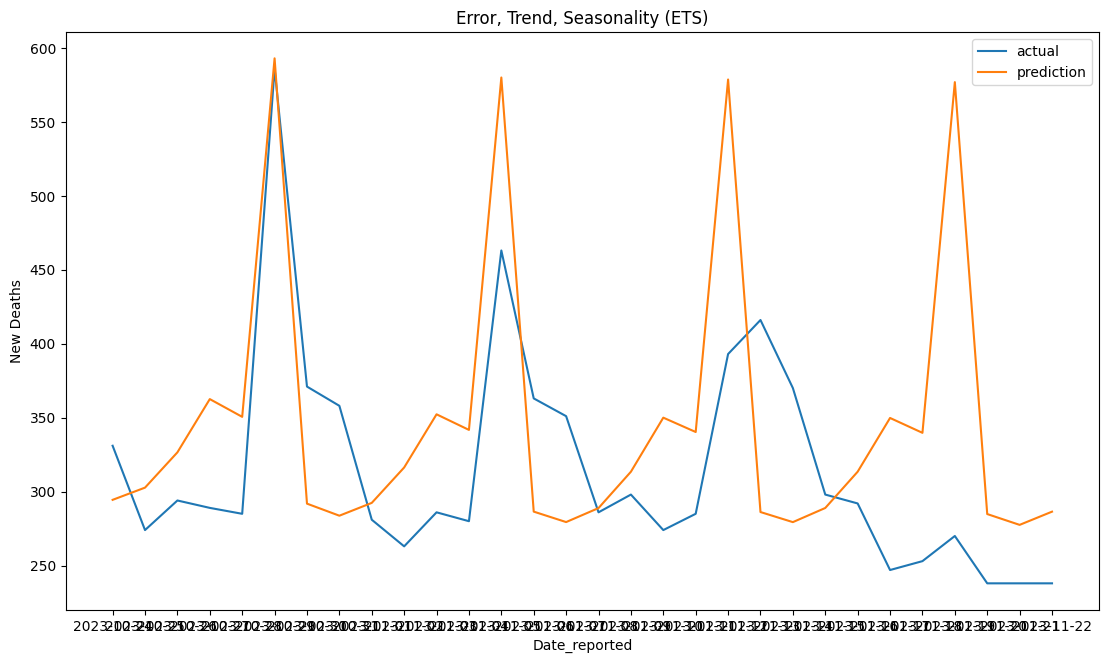

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Error, Trend, Seasonality (ETS)")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
plt.show()